# Binary Classification Deep Learning Model for Company Bankruptcy Prediction Using TensorFlow Take 3
### David Lowe
### April 8, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Company Bankruptcy Prediction dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: The research team collected the data from the Taiwan Economic Journal from 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange. Because not catching companies in a shaky financial situation is a costly business proposition, we will maximize the precision and recall ratios with the F1 score.

The data analysis first appeared on the research paper, Liang, D., Lu, C.-C., Tsai, C.-F., and Shih, G.-A. (2016) Financial Ratios and Corporate Governance Indicators in Bankruptcy Prediction: A Comprehensive Study. European Journal of Operational Research, vol. 252, no. 2, pp. 561-572.

In iteration Take1, we constructed and tuned several classic machine learning models using the Scikit-Learn library. We also observed the best results that we could obtain from the models.

In iteration Take2, we constructed and tuned a XGBoost model. We also will observe the best results that we can obtain from the model.

This Take3 iteration will construct and tune a three-layer TensorFlow model. We also will observe the best results that we can obtain from the model.

ANALYSIS: In iteration Take1, the machine learning algorithms' average performance achieved an F1 score of 94.37%. Two algorithms (Extra Trees and Random Forest) produced the top F1 metrics after the first round of modeling. After a series of tuning trials, the Extra Trees model turned in an F1 score of 97.39% using the training dataset. When we applied the Extra Tree model to the previously unseen test dataset, we obtained an F1 score of 55.55%.

In iteration Take2, the XGBoost algorithm achieved an F1 score of 96.48% using the training dataset. After a series of tuning trials, the XGBoost model turned in an F1 score of 98.38%. When we applied the XGBoost model to the previously unseen test dataset, we obtained an F1 score of 58.18%.

In this Take3 iteration, The performance of the TensorFlow model achieved an average F1 score of 67.03% after 20 epochs using the training dataset. When we applied the XGBoost model to the previously unseen test dataset, obtained an F1 score of 41.55%.

CONCLUSION: In this iteration, the TensorFlow model did not appear to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: Company Bankruptcy Prediction Data Set

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/Taiwanese+Bankruptcy+Prediction

One potential source of performance benchmark: https://www.kaggle.com/fedesoriano/company-bankruptcy-prediction

A deep-learning modeling project generally can be broken down into five major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Finalize Model and Present Analysis

# Task 1 - Prepare Environment

In [1]:
# # Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# # Retrieve GPU configuration information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# # Retrieve memory configuration information from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# # Direct Colab to use TensorFlow v2
# %tensorflow_version 2.x

In [5]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


## 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
seedNum = 8

In [7]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
import tensorflow_addons as tfa

## 1.b) Set up the controlling parameters and functions

In [8]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
NUM_CLASSES = 1
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = [tfa.metrics.F1Score(num_classes=NUM_CLASSES)]
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_INITIALIZER = tf.keras.initializers.GlorotNormal(seed=seedNum)
MAX_EPOCH = 20
BATCH_SIZE = 32

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 0
TensorFlow version: 2.4.1


In [9]:
# Set up the parent directory location for loading the dotenv files
# useColab = True
# if useColab:
#     # Mount Google Drive locally for storing files
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
#     env_path = '/content/gdrive/My Drive/Colab Notebooks/'
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# useLocalPC = True
# if useLocalPC:
#     env_path = "/Users/david/PycharmProjects/"
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

In [10]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [11]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [12]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## 1.c) Load dataset

In [13]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-company-bankruptcy-prediction/data_fedesoriano.csv'
attrNames = ['X' + str(i) for i in range(1,96)]
colNames = ['targetVar'] + attrNames
Xy_original = pd.read_csv(dataset_path, sep=',', index_col=False)
Xy_original.columns = colNames

# Take a peek at the dataframe after import
Xy_original.head()

targetVar        X1        X2        X3        X4        X5        X6        X7        X8        X9       X10           X11  \
0          1  0.370594  0.424389  0.405750  0.601457  0.601457  0.998969  0.796887  0.808809  0.302646  0.780985  1.256969e-04   
1          1  0.464291  0.538214  0.516730  0.610235  0.610235  0.998946  0.797380  0.809301  0.303556  0.781506  2.897851e-04   
2          1  0.426071  0.499019  0.472295  0.601450  0.601364  0.998857  0.796403  0.808388  0.302035  0.780284  2.361297e-04   
3          1  0.399844  0.451265  0.457733  0.583541  0.583541  0.998700  0.796967  0.808966  0.303350  0.781241  1.078888e-04   
4          1  0.465022  0.538432  0.522298  0.598783  0.598783  0.998973  0.797366  0.809304  0.303475  0.781550  7.890000e+09   

          X12       X13       X14  X15       X16       X17       X18       X19       X20       X21       X22       X23       X24  \
0         0.0  0.458143  0.000725  0.0  0.147950  0.147950  0.147950  0.169141  0.311664  0.017560  0.095921  0.138736  0.022102   
1         0.0  0.461867  0.000647  0.0  0.182251  0.182251  0.182251  0.208944  0.318137  0.021144  0.093722  0.169918  0.022080   
2  25500000.0  0.458521  0.000790  0.0  0.177911  0.177911  0.193713  0.180581  0.307102  0.005944  0.092338  0.142803  0.022760   
3         0.0  0.465705  0.000449  0.0  0.154187  0.154187  0.154187  0.193722  0.321674  0.014368  0.077762  0.148603  0.022046   
4         0.0  0.462746  0.000686  0.0  0.167502  0.167502  0.167502  0.212537  0.319162  0.029690  0.096898  0.168412  0.022096   

        X25       X26       X27       X28           X29       X30       X31       X32       X33       X34       X35       X36       X37  \
0  0.848195  0.688979  0.688979  0.217535  4.980000e+09  0.000327  0.263100  0.363725  0.002259  0.001208  0.629951  0.021266  0.207576   
1  0.848088  0.689693  0.689702  0.217620  6.110000e+09  0.000443  0.264516  0.376709  0.006016  0.004039  0.635172  0.012502  0.171176   
2  0.848094  0.689463  0.689470  0.217601  7.280000e+09  0.000396  0.264184  0.368913  0.011543  0.005348  0.629631  0.021248  0.207516   
3  0.848005  0.689110  0.689110  0.217568  4.880000e+09  0.000382  0.263371  0.384077  0.004194  0.002896  0.630228  0.009572  0.151465   
4  0.848258  0.689697  0.689697  0.217626  5.510000e+09  0.000439  0.265218  0.379690  0.006022  0.003727  0.636055  0.005150  0.106509   

        X38       X39       X40       X41       X42       X43       X44       X45       X46       X47           X48           X49  \
0  0.792424  0.005024  0.390284  0.006479  0.095885  0.137757  0.398036  0.086957  0.001814  0.003487  1.820926e-04  1.165007e-04   
1  0.828824  0.005059  0.376760  0.005835  0.093743  0.168962  0.397725  0.064468  0.001286  0.004917  9.360000e+09  7.190000e+08   
2  0.792484  0.005100  0.379093  0.006562  0.092318  0.148036  0.406580  0.014993  0.001495  0.004227  6.500000e+07  2.650000e+09   
3  0.848535  0.005047  0.379743  0.005366  0.077727  0.147561  0.397925  0.089955  0.001966  0.003215  7.130000e+09  9.150000e+09   
4  0.893491  0.005303  0.375025  0.006624  0.096927  0.167461  0.400079  0.175412  0.001449  0.004367  1.633674e-04  2.935211e-04   

        X50       X51       X52       X53       X54       X55       X56       X57       X58           X59       X60       X61       X62  \
0  0.032903  0.034164  0.392913  0.037135  0.672775  0.166673  0.190643  0.004094  0.001997  1.473360e-04  0.147308  0.334015  0.276920   
1  0.025484  0.006889  0.391590  0.012335  0.751111  0.127236  0.182419  0.014948  0.004136  1.383910e-03  0.056963  0.341106  0.289642   
2  0.013387  0.028997  0.381968  0.141016  0.829502  0.340201  0.602806  0.000991  0.006302  5.340000e+09  0.098162  0.336731  0.277456   
3  0.028065  0.015463  0.378497  0.021320  0.725754  0.161575  0.225815  0.018851  0.002961  1.010646e-03  0.098715  0.348716  0.276580   
4  0.040161  0.058111  0.394371  0.023988  0.751822  0.260330  0.358380  0.014161  0.004275  6.80463

In [14]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   targetVar  6819 non-null   int64  
 1   X1         6819 non-null   float64
 2   X2         6819 non-null   float64
 3   X3         6819 non-null   float64
 4   X4         6819 non-null   float64
 5   X5         6819 non-null   float64
 6   X6         6819 non-null   float64
 7   X7         6819 non-null   float64
 8   X8         6819 non-null   float64
 9   X9         6819 non-null   float64
 10  X10        6819 non-null   float64
 11  X11        6819 non-null   float64
 12  X12        6819 non-null   float64
 13  X13        6819 non-null   float64
 14  X14        6819 non-null   float64
 15  X15        6819 non-null   float64
 16  X16        6819 non-null   float64
 17  X17        6819 non-null   float64
 18  X18        6819 non-null   float64
 19  X19        6819 non-null   float64
 20  X20     

In [15]:
Xy_original.describe()

targetVar           X1           X2           X3           X4           X5           X6           X7           X8           X9  \
count  6819.000000  6819.000000  6819.000000  6819.000000  6819.000000  6819.000000  6819.000000  6819.000000  6819.000000  6819.000000   
mean      0.032263     0.505180     0.558625     0.553589     0.607948     0.607929     0.998755     0.797190     0.809084     0.303623   
std       0.176710     0.060686     0.065620     0.061595     0.016934     0.016916     0.013010     0.012869     0.013601     0.011163   
min       0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.476527     0.535543     0.527277     0.600445     0.600434     0.998969     0.797386     0.809312     0.303466   
50%       0.000000     0.502706     0.559802     0.552278     0.605997     0.605976     0.999022     0.797464     0.809375     0.303525   
75%       0.000000     0.535563     0.589157     0.584105     0.613914     0.613842     0.999095     0.797579     0.809469     0.303585   
max       1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000   

               X10           X11           X12          X13           X14          X15          X16          X17          X18  \
count  6819.000000  6.819000e+03  6.819000e+03  6819.000000  6.819000e+03  6819.000000  6819.000000  6819.000000  6819.000000   
mean      0.781381  1.995347e+09  1.950427e+09     0.467431  1.644801e+07     0.115001     0.190661     0.190633     0.190672   
std       0.012679  3.237684e+09  2.598292e+09     0.017036  1.082750e+08     0.138667     0.033390     0.033474     0.033480   
min       0.000000  0.000000e+00  0.000000e+00     0.000000  0.000000e+00     0.000000     0.000000     0.000000     0.000000   
25%       0.781567  1.566874e-04  1.281880e-04     0.461558  2.030203e-04     0.000000     0.173613     0.173613     0.173676   
50%       0.781635  2.777589e-04  5.090000e+08     0.465080  3.210321e-04     0.073489     0.184400     0.184400     0.184400   
75%       0.781735  4.145000e+09  3.450000e+09     0.471004  5.325533e-04     0.205841     0.199570     0.199570     0.199612   
max       1.000000  9.990000e+09  9.980000e+09     1.000000  9.900000e+08     1.000000     1.000000     1.000000     1.000000   

               X19          X20           X21          X22          X23          X24          X25          X26          X27          X28  \
count  6819.000000  6819.000000  6.819000e+03  6819.000000  6819.000000  6819.000000  6819.000000  6819.000000  6819.000000  6819.000000   
mean      0.228813     0.323482  1.328641e+06     0.109091     0.184361     0.022408     0.847980     0.689146     0.689150     0.217639   
std       0.033263     0.017611  5.170709e+07     0.027942     0.033180     0.012079     0.010752     0.013853     0.013910     0.010063   
min       0.000000     0.000000  0.000000e+00     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.214711     0.317748  1.563138e-02     0.096083     0.170370     0.022065     0.847984     0.689270     0.689270     0.217580   
50%       0.224544     0.322487  2.737571e-02     0.104226     0.179709     0.022102     0.848044     0.689439     0.689439     0.217598   
75%       0.238820     0.328623  4.635722e-02     0.116155     0.193493     0.022153     0.848123     0.689647     0.689647     0.217622   
max       1.000000     1.000000  3.020000e+09     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000   

                X29           X30          X31          X32           X33           X34          X35           X36          X37  \
count  6.819000e+03  6.819000e+03  6819.000000  6819.000000  6.819000e+03  6.819000e+03  6819.000000  6.819000e+03  6819.000000   
mean   5.508097e+09  1.566212e+06     0.264248     0.379677  4.032850e+0

In [16]:
# Surface the features that have NaNs
null_counts = Xy_original.isnull().sum()
if null_counts.sum() > 0 :
    print(null_counts[null_counts > 0])
print('Total number of NaN in the dataframe:', null_counts.sum())

Total number of NaN in the dataframe: 0


## 1.d) Data Cleaning

In [17]:
# Dropping features
Xy_original.drop(columns=['X94'], inplace=True)

# Take a peek at the dataframe after cleaning
Xy_original.head()

targetVar        X1        X2        X3        X4        X5        X6        X7        X8        X9       X10           X11  \
0          1  0.370594  0.424389  0.405750  0.601457  0.601457  0.998969  0.796887  0.808809  0.302646  0.780985  1.256969e-04   
1          1  0.464291  0.538214  0.516730  0.610235  0.610235  0.998946  0.797380  0.809301  0.303556  0.781506  2.897851e-04   
2          1  0.426071  0.499019  0.472295  0.601450  0.601364  0.998857  0.796403  0.808388  0.302035  0.780284  2.361297e-04   
3          1  0.399844  0.451265  0.457733  0.583541  0.583541  0.998700  0.796967  0.808966  0.303350  0.781241  1.078888e-04   
4          1  0.465022  0.538432  0.522298  0.598783  0.598783  0.998973  0.797366  0.809304  0.303475  0.781550  7.890000e+09   

          X12       X13       X14  X15       X16       X17       X18       X19       X20       X21       X22       X23       X24  \
0         0.0  0.458143  0.000725  0.0  0.147950  0.147950  0.147950  0.169141  0.311664  0.017560  0.095921  0.138736  0.022102   
1         0.0  0.461867  0.000647  0.0  0.182251  0.182251  0.182251  0.208944  0.318137  0.021144  0.093722  0.169918  0.022080   
2  25500000.0  0.458521  0.000790  0.0  0.177911  0.177911  0.193713  0.180581  0.307102  0.005944  0.092338  0.142803  0.022760   
3         0.0  0.465705  0.000449  0.0  0.154187  0.154187  0.154187  0.193722  0.321674  0.014368  0.077762  0.148603  0.022046   
4         0.0  0.462746  0.000686  0.0  0.167502  0.167502  0.167502  0.212537  0.319162  0.029690  0.096898  0.168412  0.022096   

        X25       X26       X27       X28           X29       X30       X31       X32       X33       X34       X35       X36       X37  \
0  0.848195  0.688979  0.688979  0.217535  4.980000e+09  0.000327  0.263100  0.363725  0.002259  0.001208  0.629951  0.021266  0.207576   
1  0.848088  0.689693  0.689702  0.217620  6.110000e+09  0.000443  0.264516  0.376709  0.006016  0.004039  0.635172  0.012502  0.171176   
2  0.848094  0.689463  0.689470  0.217601  7.280000e+09  0.000396  0.264184  0.368913  0.011543  0.005348  0.629631  0.021248  0.207516   
3  0.848005  0.689110  0.689110  0.217568  4.880000e+09  0.000382  0.263371  0.384077  0.004194  0.002896  0.630228  0.009572  0.151465   
4  0.848258  0.689697  0.689697  0.217626  5.510000e+09  0.000439  0.265218  0.379690  0.006022  0.003727  0.636055  0.005150  0.106509   

        X38       X39       X40       X41       X42       X43       X44       X45       X46       X47           X48           X49  \
0  0.792424  0.005024  0.390284  0.006479  0.095885  0.137757  0.398036  0.086957  0.001814  0.003487  1.820926e-04  1.165007e-04   
1  0.828824  0.005059  0.376760  0.005835  0.093743  0.168962  0.397725  0.064468  0.001286  0.004917  9.360000e+09  7.190000e+08   
2  0.792484  0.005100  0.379093  0.006562  0.092318  0.148036  0.406580  0.014993  0.001495  0.004227  6.500000e+07  2.650000e+09   
3  0.848535  0.005047  0.379743  0.005366  0.077727  0.147561  0.397925  0.089955  0.001966  0.003215  7.130000e+09  9.150000e+09   
4  0.893491  0.005303  0.375025  0.006624  0.096927  0.167461  0.400079  0.175412  0.001449  0.004367  1.633674e-04  2.935211e-04   

        X50       X51       X52       X53       X54       X55       X56       X57       X58           X59       X60       X61       X62  \
0  0.032903  0.034164  0.392913  0.037135  0.672775  0.166673  0.190643  0.004094  0.001997  1.473360e-04  0.147308  0.334015  0.276920   
1  0.025484  0.006889  0.391590  0.012335  0.751111  0.127236  0.182419  0.014948  0.004136  1.383910e-03  0.056963  0.341106  0.289642   
2  0.013387  0.028997  0.381968  0.141016  0.829502  0.340201  0.602806  0.000991  0.006302  5.340000e+09  0.098162  0.336731  0.277456   
3  0.028065  0.015463  0.378497  0.021320  0.725754  0.161575  0.225815  0.018851  0.002961  1.010646e-03  0.098715  0.348716  0.276580   
4  0.040161  0.058111  0.394371  0.023988  0.751822  0.260330  0.358380  0.014161  0.004275  6.80463

## 1.e) Splitting Data into Sets

In [18]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = 1

In [19]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (6819, 95) X_original.shape: (6819, 94) y_original.shape: (6819,)


In [20]:
# Split the data further into training and test datasets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=test_set_size, stratify=y_original, random_state=seedNum)
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (5455, 94) y_train_df.shape: (5455,)
X_test_df.shape: (1364, 94) y_test_df.shape: (1364,)


In [21]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Summarize and Visualize Data

In [22]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 2 - Summarize and Visualize Data has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [23]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


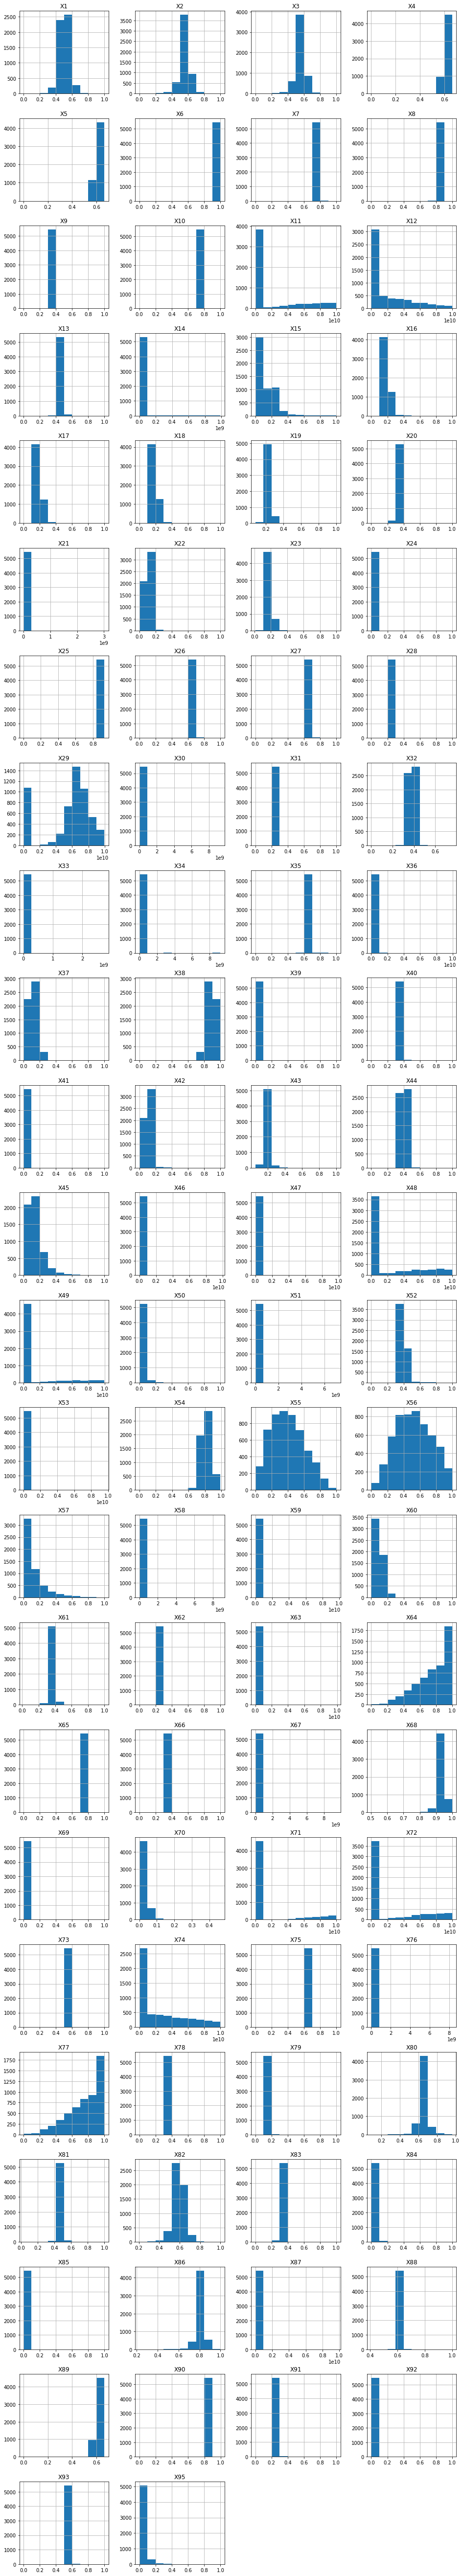

In [24]:
# Histograms for each attribute
X_train_df.hist(layout=(dispRow,dispCol))
plt.show()

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


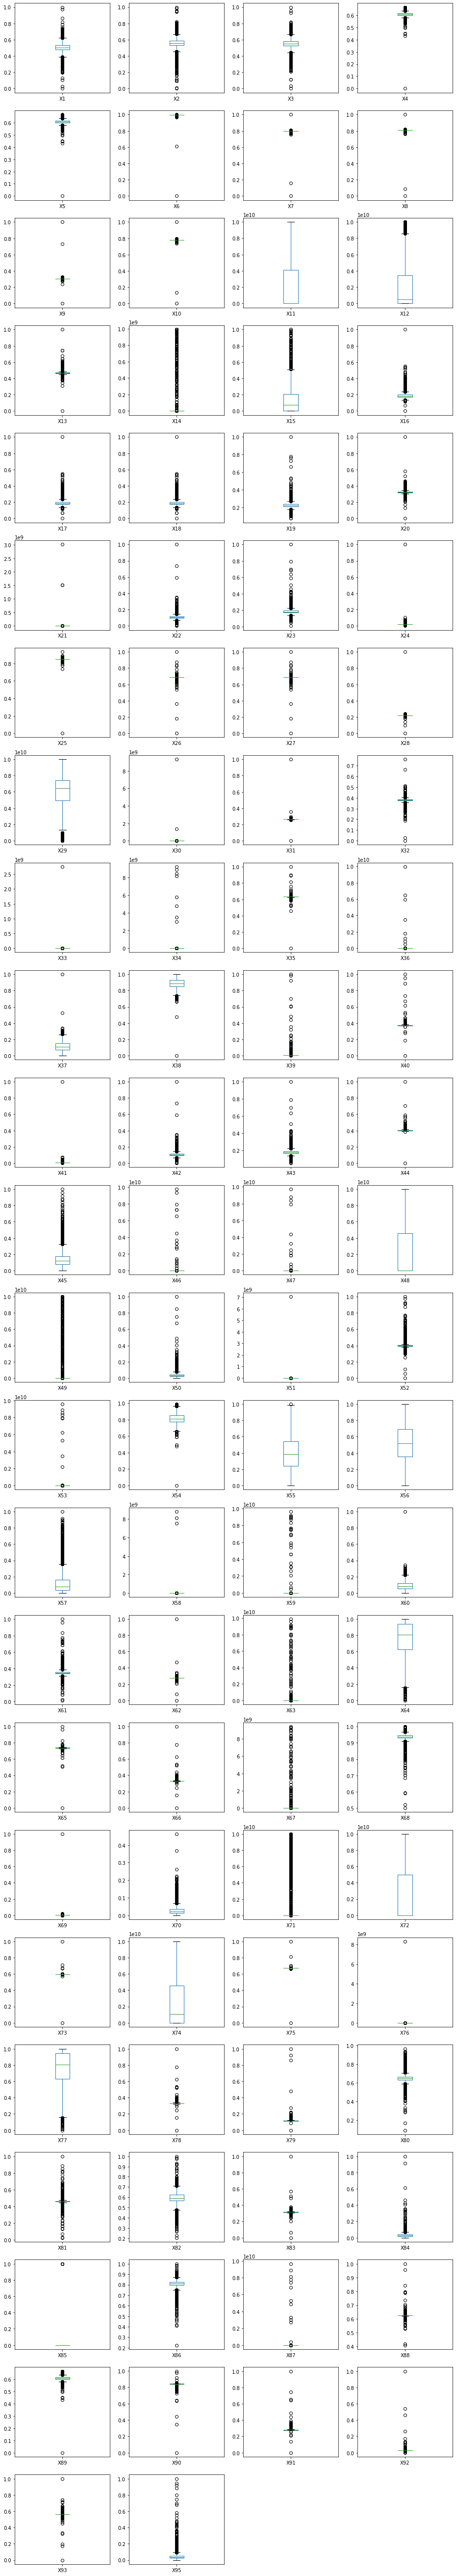

In [25]:
# Box and Whisker plot for each attribute
X_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

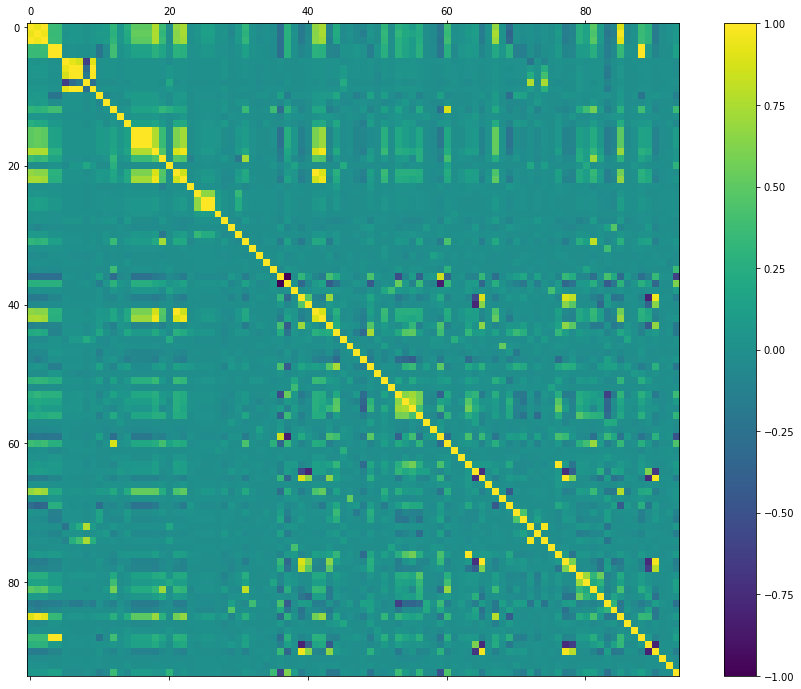

In [26]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_train_df.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [27]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 2 - Summarize and Visualize Data completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Pre-process Data

In [28]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 3 - Pre-process Data has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

### 3.a) Training Data Balancing

In [29]:
# Perform SMOTE transformation on the training data (Block #1 of 2)
X_train_imbal = X_train_df.values
y_train_imbal = y_train_df.values.ravel()
print("X_train_imbal.shape: {} y_train_imbal.shape: {}".format(X_train_imbal.shape, y_train_imbal.shape))

X_train_imbal.shape: (5455, 94) y_train_imbal.shape: (5455,)


In [30]:
# Perform SMOTE transformation on the training data (Block #2 of 2)
print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
over_sample = SMOTE(sampling_strategy=0.6, random_state=seedNum)
under_sample = RandomUnderSampler(sampling_strategy=1.0, random_state=seedNum)
steps = [('o', over_sample), ('u', under_sample)]
sample_pipeline = Pipeline(steps=steps)
X_train, y_train = sample_pipeline.fit_resample(X_train_imbal, y_train_imbal)
print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train==1).sum(), (y_train==0).sum()))

Original class distribution - 1: 176 | 0: 5279
Resampled class distribution - 1: 3167 | 0: 3167


### 3.b) Feature Scaling

In [31]:
# Apply feature scaling and transformation
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
print(X_train)

[[0.49553941 0.55162451 0.54146368 ... 0.02682768 0.18143344 0.03854421]
 [0.46682592 0.5412669  0.52138765 ... 0.02679116 0.18111642 0.04600523]
 [0.45273729 0.50528783 0.50329247 ... 0.02664756 0.17962425 0.01636886]
 ...
 [0.44202411 0.36184023 0.47949136 ... 0.02845019 0.18403902 0.01345246]
 [0.46321196 0.52611533 0.51642126 ... 0.0260456  0.157876   0.01993529]
 [0.45050241 0.50218869 0.49937291 ... 0.02628865 0.16797748 0.02319015]]


### 3.c) Display the Final Datasets for Model-Building

In [32]:
# Finalize the training and validation datasets for the modeling activities
# X_train = X_train_df.to_numpy()
# y_train = y_train_df.ravel()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))

X_train.shape: (6334, 94) y_train.shape: (6334,)


In [33]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 3 - Pre-process Data completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Train and Evaluate Models

In [34]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 4 - Train and Evaluate Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [35]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=X_train.shape[1], output_param=NUM_CLASSES, layer1_nodes=512, layer2_nodes=256, layer3_nodes=128, layer1_dropout=0.25, layer2_dropout=0.25, layer3_dropout=0.25,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS, init_param=DEFAULT_INITIALIZER):
    nn_model = keras.Sequential([
        keras.layers.Dense(layer1_nodes, input_shape=(input_param,), activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer1_dropout),
        keras.layers.Dense(layer2_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer2_dropout),
        keras.layers.Dense(layer3_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer3_dropout),
        keras.layers.Dense(output_param, activation='sigmoid', kernel_initializer=init_param)
    ])
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [36]:
# Initialize the default model and get a baseline result
startTimeModule = datetime.now()
results = list()
iteration = 0
cv = RepeatedKFold(n_splits=N_FOLDS, n_repeats=N_ITERATIONS, random_state=seedNum)
for train_ix, val_ix in cv.split(X_train):
    feature_train, feature_validation = X_train[train_ix], X_train[val_ix]
    target_train, target_validation = y_train[train_ix], y_train[val_ix]
    reset_random(seedNum)
    baseline_model = create_nn_model()
    baseline_model.fit(feature_train, target_train, epochs=MAX_EPOCH, batch_size=BATCH_SIZE, verbose=0)
    model_metric = baseline_model.evaluate(feature_validation, target_validation, verbose=1)[1]
    iteration = iteration + 1
    print('F1 score from iteration %d >>> %.4f' % (iteration, model_metric))
    results.append(model_metric)
validation_score = np.mean(results)
validation_variance = np.std(results)
print('Average model F1 score from all iterations: %.4f (%.4f)' % (validation_score, validation_variance))
print('Total time for model fitting and cross validating:', (datetime.now() - startTimeModule))

40/40 [==============================] - 0s 2ms/step - loss: 0.2339 - f1_score: 0.6789
F1 score from iteration 1 >>> 0.6789
40/40 [==============================] - 0s 2ms/step - loss: 0.1778 - f1_score: 0.6574
F1 score from iteration 2 >>> 0.6574
40/40 [==============================] - 0s 2ms/step - loss: 0.2540 - f1_score: 0.6560
F1 score from iteration 3 >>> 0.6560
40/40 [==============================] - 0s 2ms/step - loss: 0.2240 - f1_score: 0.6800
F1 score from iteration 4 >>> 0.6800
40/40 [==============================] - 0s 2ms/step - loss: 0.2135 - f1_score: 0.6794
F1 score from iteration 5 >>> 0.6794
Average model F1 score from all iterations: 0.6703 (0.0111)
Total time for model fitting and cross validating: 0:01:21.868918


In [37]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 4 - Train and Evaluate Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Present Analysis

In [38]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 5 - Finalize Model and Present Analysis has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [39]:
final_model = create_nn_model()
final_model.fit(X_train, y_train, epochs=MAX_EPOCH, batch_size=BATCH_SIZE, verbose=0)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

# Summarize the test model
final_model.summary()

Total time for model fitting: 0:01:41.439844
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 512)               48640     
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 

In [40]:
# Apply feature scaling and transformation to the test dataset
X_test = scaler.transform(X_test_df)
print(X_test)

[[0.4803783  0.53418011 0.52909685 ... 0.02679126 0.18111736 0.13682596]
 [0.59103983 0.63939163 0.62010814 ... 0.02680203 0.18121303 0.05649015]
 [0.52985911 0.58722198 0.57481664 ... 0.02680978 0.18128072 0.03131672]
 ...
 [0.50684932 0.57168556 0.55763156 ... 0.02681569 0.18133176 0.07088829]
 [0.4680934  0.52523986 0.51924621 ... 0.02643608 0.17631452 0.06648556]
 [0.53531907 0.59757959 0.5870764  ... 0.02683167 0.18146678 0.04122032]]


In [41]:
# Finalize the test dataset for the modeling testing
# X_test = X_test_df.to_numpy()
y_test = y_test_df.ravel()
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_test.shape: (1364, 94) y_test.shape: (1364,)


In [42]:
# test_predictions = final_model.predict(X_test, batch_size=default_batch, verbose=1)
test_predictions = (final_model.predict(X_test) > 0.5).astype("int32").ravel()
print('F1 Score:', f1_score(y_test, test_predictions))
print('ROC/AUC Score:', roc_auc_score(y_test, test_predictions))
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))

F1 Score: 0.4155844155844156
ROC/AUC Score: 0.8340909090909091
[[1242   78]
 [  12   32]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1320
           1       0.29      0.73      0.42        44

    accuracy                           0.93      1364
   macro avg       0.64      0.83      0.69      1364
weighted avg       0.97      0.93      0.95      1364



In [43]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 5 - Finalize Model and Present Analysis completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [44]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:02:42.589203
